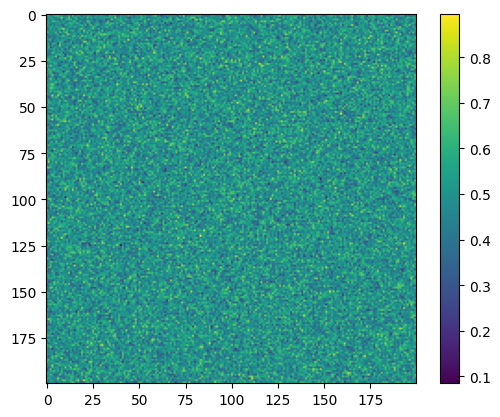

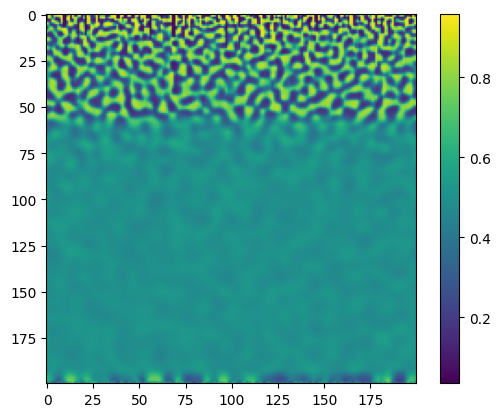

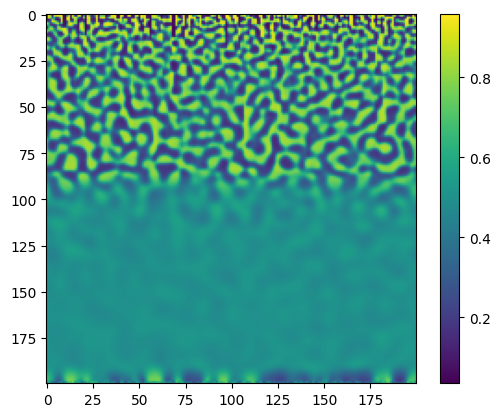

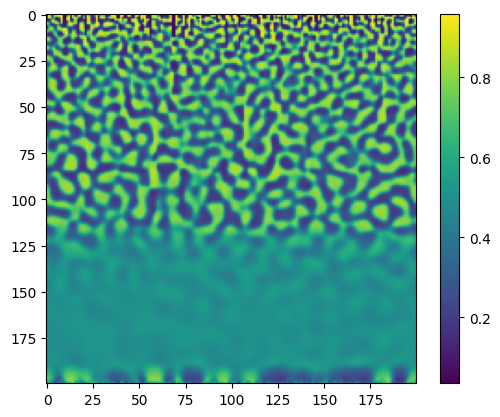

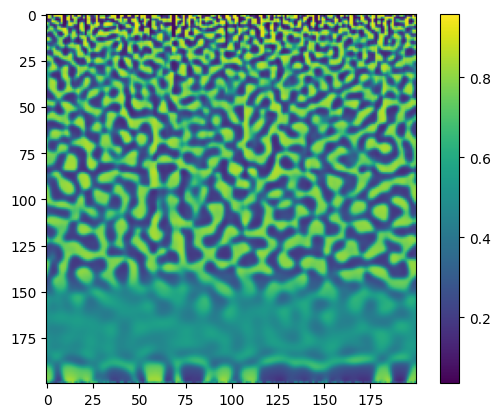

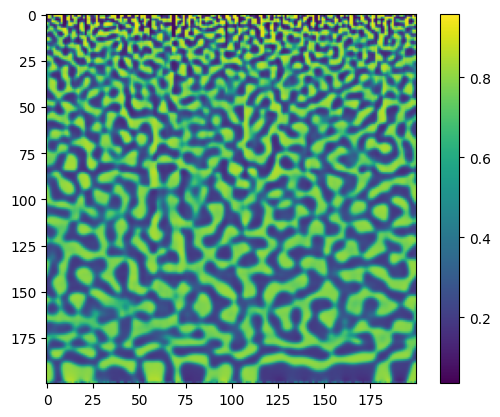

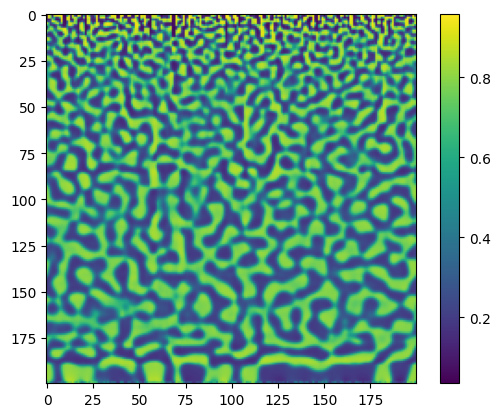

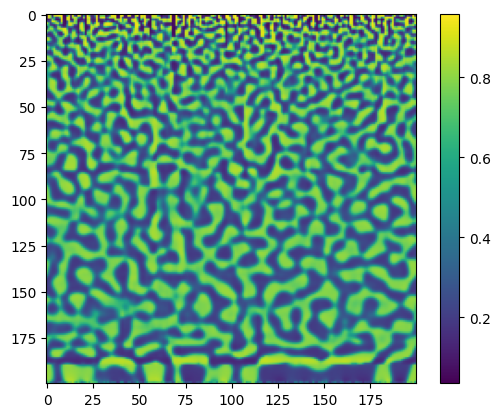

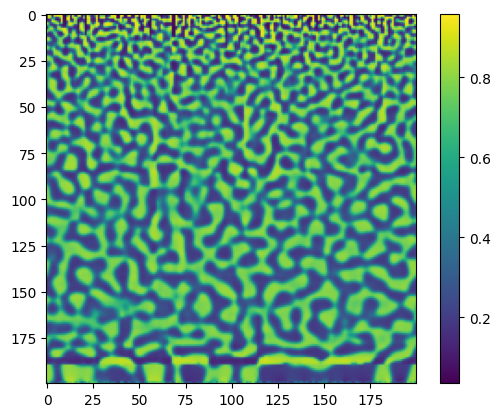

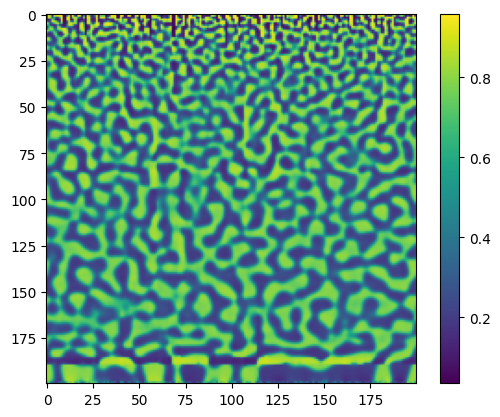

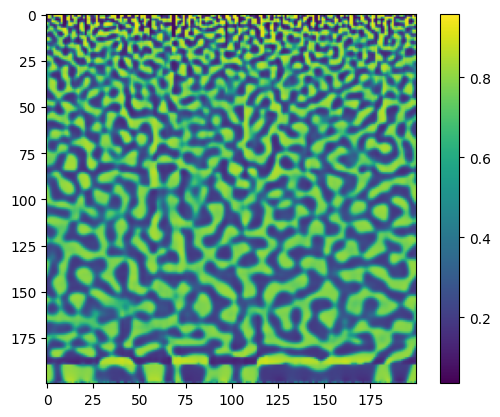

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import simpson


Nx = 200
Ny = 200
phi = 0.5  #
phis = 0.5

class Liquid:
    def __init__(
        self,
        phi0,
        chi,
        kappa: float,
        M,
        Nx,
        Ny,
        dt=0.50,
        dx=1.0,
        noise=0.1,
    ):
        self.phi0 = phi0
        self.chi = chi
        self.kappa = kappa
        self.M = M
        self.Nx, self.Ny = Nx, Ny
        self.dt = dt,
        self.dx = dx
        self.phi = (
            self.phi0 + noise * np.random.standard_normal((Ny, Nx))
        )

        self.phimin = fsolve(
            lambda x: np.log(x / (1 -x)) + self.chi * (1 - 2 * x), 0.01
        )
        self.phimax = 1 - self.phimin

    def calc_laplacian(self, F):
        Ny, Nx = F.shape

        laplacian_x = np.zeros(F.shape)
        laplacian_y = np.zeros(F.shape)

        # 周期境界条件の適用
        # X軸
        laplacian_x[:, 1: Nx - 1] = (
            -2 * F[:, 1: Nx - 1] + F[:, 2: Nx] + F[:, 0: Nx - 2]
        ) / (self.dx**2)
        laplacian_x[:, 0] = (
            -2 * F[:, 0] + F[:, 1] + F[:, Nx-1]
        ) / (self.dx**2)
        laplacian_x[:, Nx - 1] = (
            -2 * F[:, Nx - 1] + F[:, Nx - 2] + F[:, 0]
        ) / self.dx**2

        # Y軸
        laplacian_y[1: Ny - 1, :] = (
            -2 * F[1: Ny-1, :] + F[2: Ny, :] + F[0: Ny - 2, :]
        ) / (self.dx**2)
        laplacian_y[0, :] = (-1 * F[0, :] + F[1, :]) / (self.dx**2)
        laplacian_y[Ny - 1, :] = (-1 * F[Ny - 1, :] + F[Ny - 2, :]) / (self.dx**2)

        laplacian = laplacian_x + laplacian_y

        return laplacian

    def calc_gradient(self, F):
        Ny, Nx = F.shape

        gradient_x = np.zeros(F.shape)
        gradient_y = np.zeros(F.shape)

        # 周期境界条件の適用
        # X軸
        gradient_x[:, 1: Nx - 1] = (F[:, 2: Nx] - F[:, 0: Nx - 2]) / (2 * self.dx)
        gradient_x[:, 0] = (F[:, 1] - F[:, Nx - 1]) / (2 * self.dx)
        gradient_x[:, Nx - 1] = (F[:, 0] - F[:, Nx - 2]) / (2 * self.dx)

        # Y軸
        gradient_y[1: Ny - 1, :] = (F[2: Ny, :] - F[0: Ny - 2, :]) / (2 * self.dx)
        gradient_y[0, :] = (F[1, :] - F[0, :]) / (2 * self.dx)
        gradient_y[Ny - 1, :] = (F[Ny - 1, :] - F[Ny - 2, :]) / (2 * self.dx)

        gradient = (gradient_x, gradient_y)

        return gradient


    def calc_chi(self, phi_s, phi_sc=0.5):
        """
        Oil / 水 相互作用パラメータχの溶媒体積分率の値
        χ(φs) = χ0 - (χ0 - χc) φs / φsc

        φs: 溶媒の体積分率
        φsc:
        χ0: 溶媒が存在しない時のOil / 水の相互作用パラメータ
        χc: い相分離が発生する口語作用パラメータの臨界値。自由エネルギー密度の正則解の記述ではχc=2。
        """
        chi_c = 2.0

        return self.chi - (self.chi - chi_c) * phi_s / phi_sc

    def test_laplacian(self, F):
        laplacian_x = (
            np.roll(F, 1, axis=1) + np.roll(F, -1, axis=1) - 2 * F
        ) / self.dx**2
        laplacian_y = (
            np.roll(F, 1, axis=0) + np.roll(F, -1, axis=0) - 2 * F
        ) / self.dx**2
        return laplacian_x + laplacian_y

    def propagete(self, phi, chi):
        """
        μ = δF / δφ = ∂f / ∂φ - κ∇^2 φ
        f = α(φlnφ + (1-φ)ln(1-φ) + χφ(1 - φ))
        ∂f / ∂φ = α(ln(φ / (1 - φ)) + χ(1 - 2φ))

        ∂φ / ∂t = ∇・(M∇μ) = M∇^2μ
        """
        # mu = (
        #     np.log(phi / (1 - phi))
        #     + chi * (1 - 2 * phi)
        #     - self.kappa * self.calc_laplacian(phi)
        # )

        # self.phi += (self.M * self.calc_laplacian(mu)) * self.dt
        mu = (
            np.log(phi / (1 - phi))
            + chi * (1 - 2 * phi)
            - self.kappa * self.test_laplacian(phi)
        )

        self.phi += (self.M * self.test_laplacian(mu)) * self.dt

        return self.phi

    def calc_free_energy(self, phi):
        gradient_phi = self.calc_gradient(phi)
        # print(f"test1: {gradient_phi}")
        # print(f"test2: {np.gradient(phi)}")
        # gradient_phi = np.gradient(phi, self.dx)

        # f = α(φlnφ + (1 -φ)ln(1 - φ) + χφ(1-φ))
        free_energy_bulk = np.sum(
            phi * np.log(phi) + (1 - phi) * np.log(1 - phi) + self.chi * phi * (1 - phi)
        )

        # 1/2κ|∇φ|^2
        free_energy_interface = np.sum(
            1 / 2 * self.kappa * (gradient_phi[0]**2 + gradient_phi[1]**2)
        )

        # F = ∫dV[f + 1/2κ|∇φ|^2]
        free_energy = free_energy_bulk + free_energy_interface

        return (free_energy_bulk, free_energy_interface, free_energy)

    def calc_IFT(self, phi):
        """
        水平方向の寄与（σx）と垂直方向の寄与（σy）の幾何平均をとって
        局所的な界面張力（IFT）を計算する関数
        """
        grad_x, grad_y = self.calc_gradient(phi)
        # grad_x, grad_y = np.gradient(phi, self.dx)
        # σx = κ∫dx[∂φ/∂x]^2
        sigma_x = self.kappa * simpson(grad_x**2, axis=1)
        sigma_y = self.kappa * simpson(grad_y**2, axis=0)
        # σ=√σx σy
        sigma = np.sqrt(
            (np.ones(phi.shape) * np.atleast_2d(sigma_x).transpose()) * sigma_y
        )

        return sigma

    def arrest(self, phi):
        """
        界面張力が臨界値に達した後、移動度を極端に下げることで相分離を止める。
        """
        sigma_c = 1.0
        check = np.copy(self.calc_IFT(phi))

        if sigma_c >= 1.0:
            check[check < sigma_c] = 1
            check[check > sigma_c] = 10**-6

        if sigma_c < 1.0:
            check2 = np.copy(check)
            check[check < sigma_c] = 1
            check[check2 > sigma_c] = 10**-6

        self.M = self.M * check

        return self.M



class Solvent:
    def __init__(
        self,
        phi0,
        Nx,
        Ny,
        bc_t=0,  # 溶媒秩序パラメータ境界条件(top)
        dt=0.50,
        dx=1.0,
    ):
        self.phi0 = phi0
        self.Nx, self.Ny = Nx, Ny
        self.bc_t = bc_t
        self.dt = dt
        self.dx = dx
        self.phi = np.zeros((Ny, Nx)) + self.phi0

    def calc_laplacian(self, F):
        Ny, Nx = F.shape

        laplacian_x = np.zeros(F.shape)
        laplacian_y = np.zeros(F.shape)

        #
        # X軸
        laplacian_x[:, 1: Nx - 1] = (
            -2 * F[:, 1: Nx - 1] + F[:, 2: Nx] + F[:, 0: Nx - 2]
        ) / (self.dx**2)
        laplacian_x[:, 0] = (
            -2 * F[:, 0] + F[:, 1] + F[:, Nx-1]
        ) / (self.dx**2)
        laplacian_x[:, Nx - 1] = (
            -2 * F[:, Nx - 1] + F[:, Nx - 2] + F[:, 0]
        ) / self.dx**2

        # Y軸
        laplacian_y[1: Ny - 1, :] = (
            -2 * F[1: Ny-1, :] + F[2: Ny, :] + F[0: Ny - 2, :]
        ) / (self.dx**2)
        laplacian_y[0, :] = (
            -2 * F[0, :] + F[1, :] + self.bc_t
        ) / (self.dx**2)
        laplacian_y[Ny - 1, :] = (
            -1 * F[Ny - 1, :] + F[Ny - 2, :]
        ) / (self.dx**2)

        laplacian = laplacian_x + laplacian_y

        return laplacian

    def Propagate(self, phi):
        # Update the order parameter field
        self.phi += (self.calc_laplacian(phi)) * self.dt

        return self.phi

Nx, Ny = 200, 200

phi0 = 0.5
phis0 = 1 - phi0
# phis0 = 0.5

oil = Liquid(phi0, chi=4, kappa=0.5, M=0.01, Nx=Nx, Ny=Ny)
solvent = Solvent(phis0, Nx=Nx, Ny=Ny, bc_t=0)

system_energy = []
system_energy.append(oil.calc_free_energy(oil.phi))

n_step = 30000

for n in range(n_step + 1):
    chi = oil.calc_chi(solvent.phi)
    oil.arrest(oil.phi)
    oil.propagete(oil.phi, chi)
    solvent.Propagate(solvent.phi)
    system_energy.append(oil.calc_free_energy(oil.phi))

    if n % int(n_step / 10) == 0:
        plt.figure()
        plt.imshow(oil.phi)
        plt.colorbar()
        plt.show()


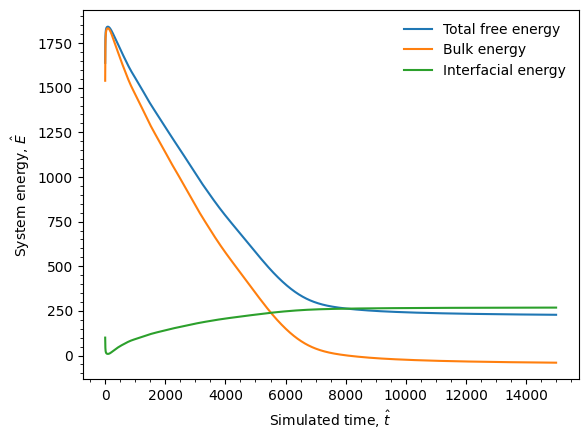

In [10]:
Bulk = []
Interface = []
Total = []

for i in range(len(system_energy)):
    Bulk.append(system_energy[i][0])
    Interface.append(system_energy[i][1])
    Total.append(system_energy[i][2])

plt.figure()
plt.minorticks_on()
plt.xlabel("Simulated time, $\hat{t}$")
plt.ylabel("System energy, $\hat{E}$")

# Simulated time (reduced units)
t_sim = np.arange(0, n_step + 2, 1) * oil.dt

plt.plot(t_sim, Total, label="Total free energy")
plt.plot(t_sim, Bulk, label="Bulk energy")
plt.plot(t_sim, Interface, label="Interfacial energy")

plt.legend(frameon="")